### Visualizing WOW data associated to Storm Poly (July 5th, 2023)
This notebook shows the observations collected by WOW-NL during the passing of Storm Poly on July 5th, 2023. The observations have been (manually) fetched from the WOW Livestream and uploaded to this virtual research environment (VRE) deployed to work with WOW data. The following is a simple recipe to visualize these observations that will hopefully trigger further discussion on the usage of third-party data (3PD) at KNMI.

In [6]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 500
pd.options.display.width = 0

cols_to_show = ["SiteId", "ReportEndDateTime", "Latitude", "Longitude", "WindSpeed_MetrePerSecond", "IsOfficial", "WindDirection"]

# Reading raw observations coming from the WOW Livestream. It's a CSV 
# file (~60MB) containing the observations from 00:00 until 17:00. 
path_in = r"./NL_WOW_Obs_05Jul23_Storm_Poly.csv"
df = pd.read_csv(path_in, sep=";", header=0, index_col=0, parse_dates=["CreatedDateTime", "LocalReportEndDateTime", "ReportEndDateTime"])

# To simplify further processing, we subset the dataframe to use only 
# the columns above. Un/Comment the line below to see the full list of
# features
df = df[cols_to_show]

# Let's calculate the U, V components of wind from the columns "WindDirection"
# and "Windspeed_MetrePerSecond". We take sin/cos operations. Please check if
# this is the wrong conversion between wind representations.
df["U"] = df["WindSpeed_MetrePerSecond"] * np.cos(df["WindDirection"])
df["V"] = df["WindSpeed_MetrePerSecond"] * np.sin(df["WindDirection"])

# Let's divide the dataframe using the 'IsOfficial' parameter, so that we
# separate between WOW stations and KNMI stations
mask = df["IsOfficial"] == 0
df_wow = df[mask]     
df_off = df[~mask]

print("Number of WOW observations: ", df_wow.shape)
print("Number of official observations: ", df_off.shape)
print("Column types: ", df_wow.dtypes)

/tmp/ipykernel_3316/374941464.py:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_in, sep=";", header=0, index_col=0, parse_dates=["CreatedDateTime", "LocalReportEndDateTime", "ReportEndDateTime"])


Number of WOW observations:  (308945, 9)
Number of official observations:  (4257, 9)
Column types:  SiteId                              object
ReportEndDateTime           datetime64[ns]
Latitude                           float64
Longitude                          float64
WindSpeed_MetrePerSecond           float64
IsOfficial                           int64
WindDirection                      float64
U                                  float64
V                                  float64
dtype: object


Now we turn the raw data into a geodataframe to ease plotting slices of data. Base cartography is provided by `cartopy`. Since now WOW-NL contains stations in the Caribbean, we focus the extent in continental Netherlands using a bounding box that `matplotlib` (underlying `pandas`) can understand.

<GeoAxes: >

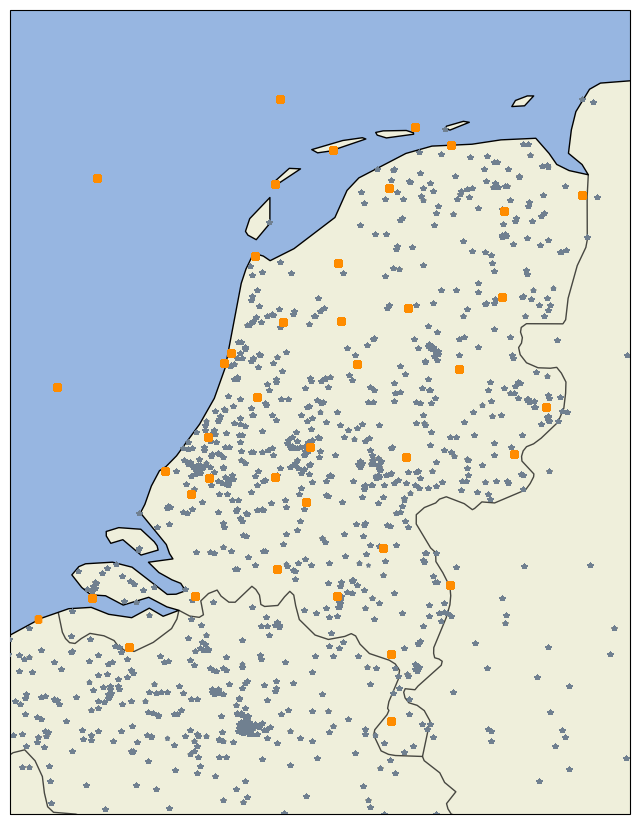

In [7]:
import cartopy
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

# Rough bbox for the Netherlands
extent = (3, 7.5, 50.5, 54)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Loading cartopy's pre-built real-world features
resolution = '50m'  # use data at this scale
boundaries = cartopy.feature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale=resolution, facecolor='none', alpha=0.7)
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale=resolution, edgecolor='k',facecolor=cfeature.COLORS['land'])
ocean = cartopy.feature.NaturalEarthFeature('physical', 'ocean', scale=resolution, edgecolor='none', facecolor=cfeature.COLORS['water'])
lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes', scale=resolution, edgecolor='k', facecolor=cfeature.COLORS['water'])

# Adding features to the map
ax.set_extent(extent)
ax.add_feature(boundaries, zorder=3)
ax.add_feature(land, zorder=2)
ax.add_feature(ocean, zorder=0)
ax.add_feature(lakes, zorder=1)

# We plot all the observations at once
gdf_wow = gpd.GeoDataFrame(df_wow, geometry=gpd.points_from_xy(df_wow.Longitude, df_wow.Latitude), crs="epsg:4326")
gdf_off = gpd.GeoDataFrame(df_off, geometry=gpd.points_from_xy(df_off.Longitude, df_off.Latitude), crs="epsg:4326")
gdf_wow.plot(ax=ax, marker="o", markersize=8, color="slategrey", zorder=4)
gdf_off.plot(ax=ax, marker="s", markersize=16, color="darkorange", zorder=4)

Now the idea is creating a minimap for each of the hours available in the CSV file. Here it is necessary to group first by `hour`, then by `SiteId`. The resulting dataframes are dismounted to calculate the mean, since `pandas` does not allow batch averaging on columns that are not numeric (e.g. `SiteId`). The relevant columns (e.g. `Longitude`, `Latitude` and `WindSpeed_MetrePerSecond` are extracted, averaged, and shown as a scatter plot. 

In [3]:
import datetime
import itertools

# Temporally inactivate inline plotting until next cell is done
%matplotlib agg
%matplotlib agg

# plt.rcParams['figure.figsize'] = [40, 32]

# Setting up some auxiliary variables
rows = range(0, 4)
cols = range(0, 6)
pairs = list(itertools.product(rows, cols))
sd = datetime.datetime(2023, 7, 5, 0, 0, 0)
ed = datetime.datetime(2023, 7, 6, 0, 0, 0)
label_dates = pd.date_range(start=sd, end=ed, freq="H")[:-1]

# Making room for the final figure
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(40, 32), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(hspace=0.3)
plt.suptitle("Storm Poly as measured by the WOW network (July 5th, 2023) ", size=24, y=0.92)

groups_time_wow = gdf_wow.groupby(gdf_wow["ReportEndDateTime"].dt.hour)
groups_time_off = gdf_off.groupby(gdf_off["ReportEndDateTime"].dt.hour)

              
i = 0
print("\nProcessing WOW observations: ")
print("-" * 30)
print()
for name_hour, group_time in groups_time_wow:
    r, c = pairs[i]

    # print("Min/max in this hour: ", group_time["WindSpeed_MetrePerSecond"].min(), group_time["WindSpeed_MetrePerSecond"].max())
    # print("Uniques: ", np.unique(group_time["WindSpeed_MetrePerSecond"], return_counts=True))
    
    # Adding the map elements defined at the beginning of the notebook
    ax[r, c].set_extent(extent)
    ax[r, c].set_title(label_dates[name_hour], size=18)
    ax[r, c].add_feature(boundaries, zorder=3)
    ax[r, c].add_feature(land, zorder=2)
    ax[r, c].add_feature(ocean, zorder=0)
    ax[r, c].add_feature(lakes, zorder=1)

    # Grouping by station and dismounting the dataframe for the plotting
    lons, lats, ucom, vcom = [[] for i in range(4)]
    groups_station_wow = group_time.groupby(["SiteId"])

    for name_station, group_station in groups_station_wow:                   
        mean_group_station = group_station[["Longitude", "Latitude", "WindSpeed_MetrePerSecond", "U", "V"]].mean()        

        if mean_group_station["WindSpeed_MetrePerSecond"] <= 40:
        
            # In theory, extraction should not be needed, but I have detected a few side effects
            lons.append(mean_group_station["Longitude"])
            lats.append(mean_group_station["Latitude"])
            ucom.append(mean_group_station["U"])
            vcom.append(mean_group_station["V"])
       
    print("Hour {0}, total WOW obs: {1} \t Avg. per (SiteId, hour): {2} \t Any official value? {3}".format(name_hour, group_time.shape, len(lons), df_wow.IsOfficial.any()))

    # Toggle these lines to have a scatter plot or quiver plots (wind direction)
    # scatter_plot = ax[r, c].scatter(lons, lats, c=vals, cmap=plt.cm.PuRd, marker="s", s=20, vmin=0, vmax=32, zorder=4)
    quiver_plot = ax[r, c].quiver(lons, lats, ucom, vcom, color="blue", zorder=4)

    i += 1  



Processing WOW observations: 
------------------------------

Hour 0, total WOW obs: (11406, 10) 	 Avg. per (SiteId, hour): 1339 	 Any official value? False
Hour 1, total WOW obs: (9081, 10) 	 Avg. per (SiteId, hour): 1339 	 Any official value? False
Hour 2, total WOW obs: (10982, 10) 	 Avg. per (SiteId, hour): 1341 	 Any official value? False
Hour 3, total WOW obs: (12793, 10) 	 Avg. per (SiteId, hour): 1350 	 Any official value? False
Hour 4, total WOW obs: (13184, 10) 	 Avg. per (SiteId, hour): 1346 	 Any official value? False
Hour 5, total WOW obs: (10662, 10) 	 Avg. per (SiteId, hour): 1353 	 Any official value? False
Hour 6, total WOW obs: (10660, 10) 	 Avg. per (SiteId, hour): 1352 	 Any official value? False
Hour 7, total WOW obs: (11192, 10) 	 Avg. per (SiteId, hour): 1354 	 Any official value? False
Hour 8, total WOW obs: (13260, 10) 	 Avg. per (SiteId, hour): 1357 	 Any official value? False
Hour 9, total WOW obs: (13912, 10) 	 Avg. per (SiteId, hour): 1360 	 Any official v

Now we add the observations coming from the KNMI network. Note that here we do not add the map formatting as before, since this one is already in.


Processing KNMI observations:
------------------------------

Hour 0, total KNMI obs: (135, 10) 	 Avg. per (SiteId, hour): 44 	 Any official value? True
Hour 1, total KNMI obs: (126, 10) 	 Avg. per (SiteId, hour): 42 	 Any official value? True
Hour 2, total KNMI obs: (171, 10) 	 Avg. per (SiteId, hour): 45 	 Any official value? True
Hour 3, total KNMI obs: (171, 10) 	 Avg. per (SiteId, hour): 43 	 Any official value? True
Hour 4, total KNMI obs: (211, 10) 	 Avg. per (SiteId, hour): 44 	 Any official value? True
Hour 5, total KNMI obs: (170, 10) 	 Avg. per (SiteId, hour): 44 	 Any official value? True
Hour 6, total KNMI obs: (125, 10) 	 Avg. per (SiteId, hour): 42 	 Any official value? True
Hour 7, total KNMI obs: (133, 10) 	 Avg. per (SiteId, hour): 45 	 Any official value? True
Hour 8, total KNMI obs: (141, 10) 	 Avg. per (SiteId, hour): 44 	 Any official value? True
Hour 9, total KNMI obs: (163, 10) 	 Avg. per (SiteId, hour): 44 	 Any official value? True
Hour 10, total KNMI obs: (1

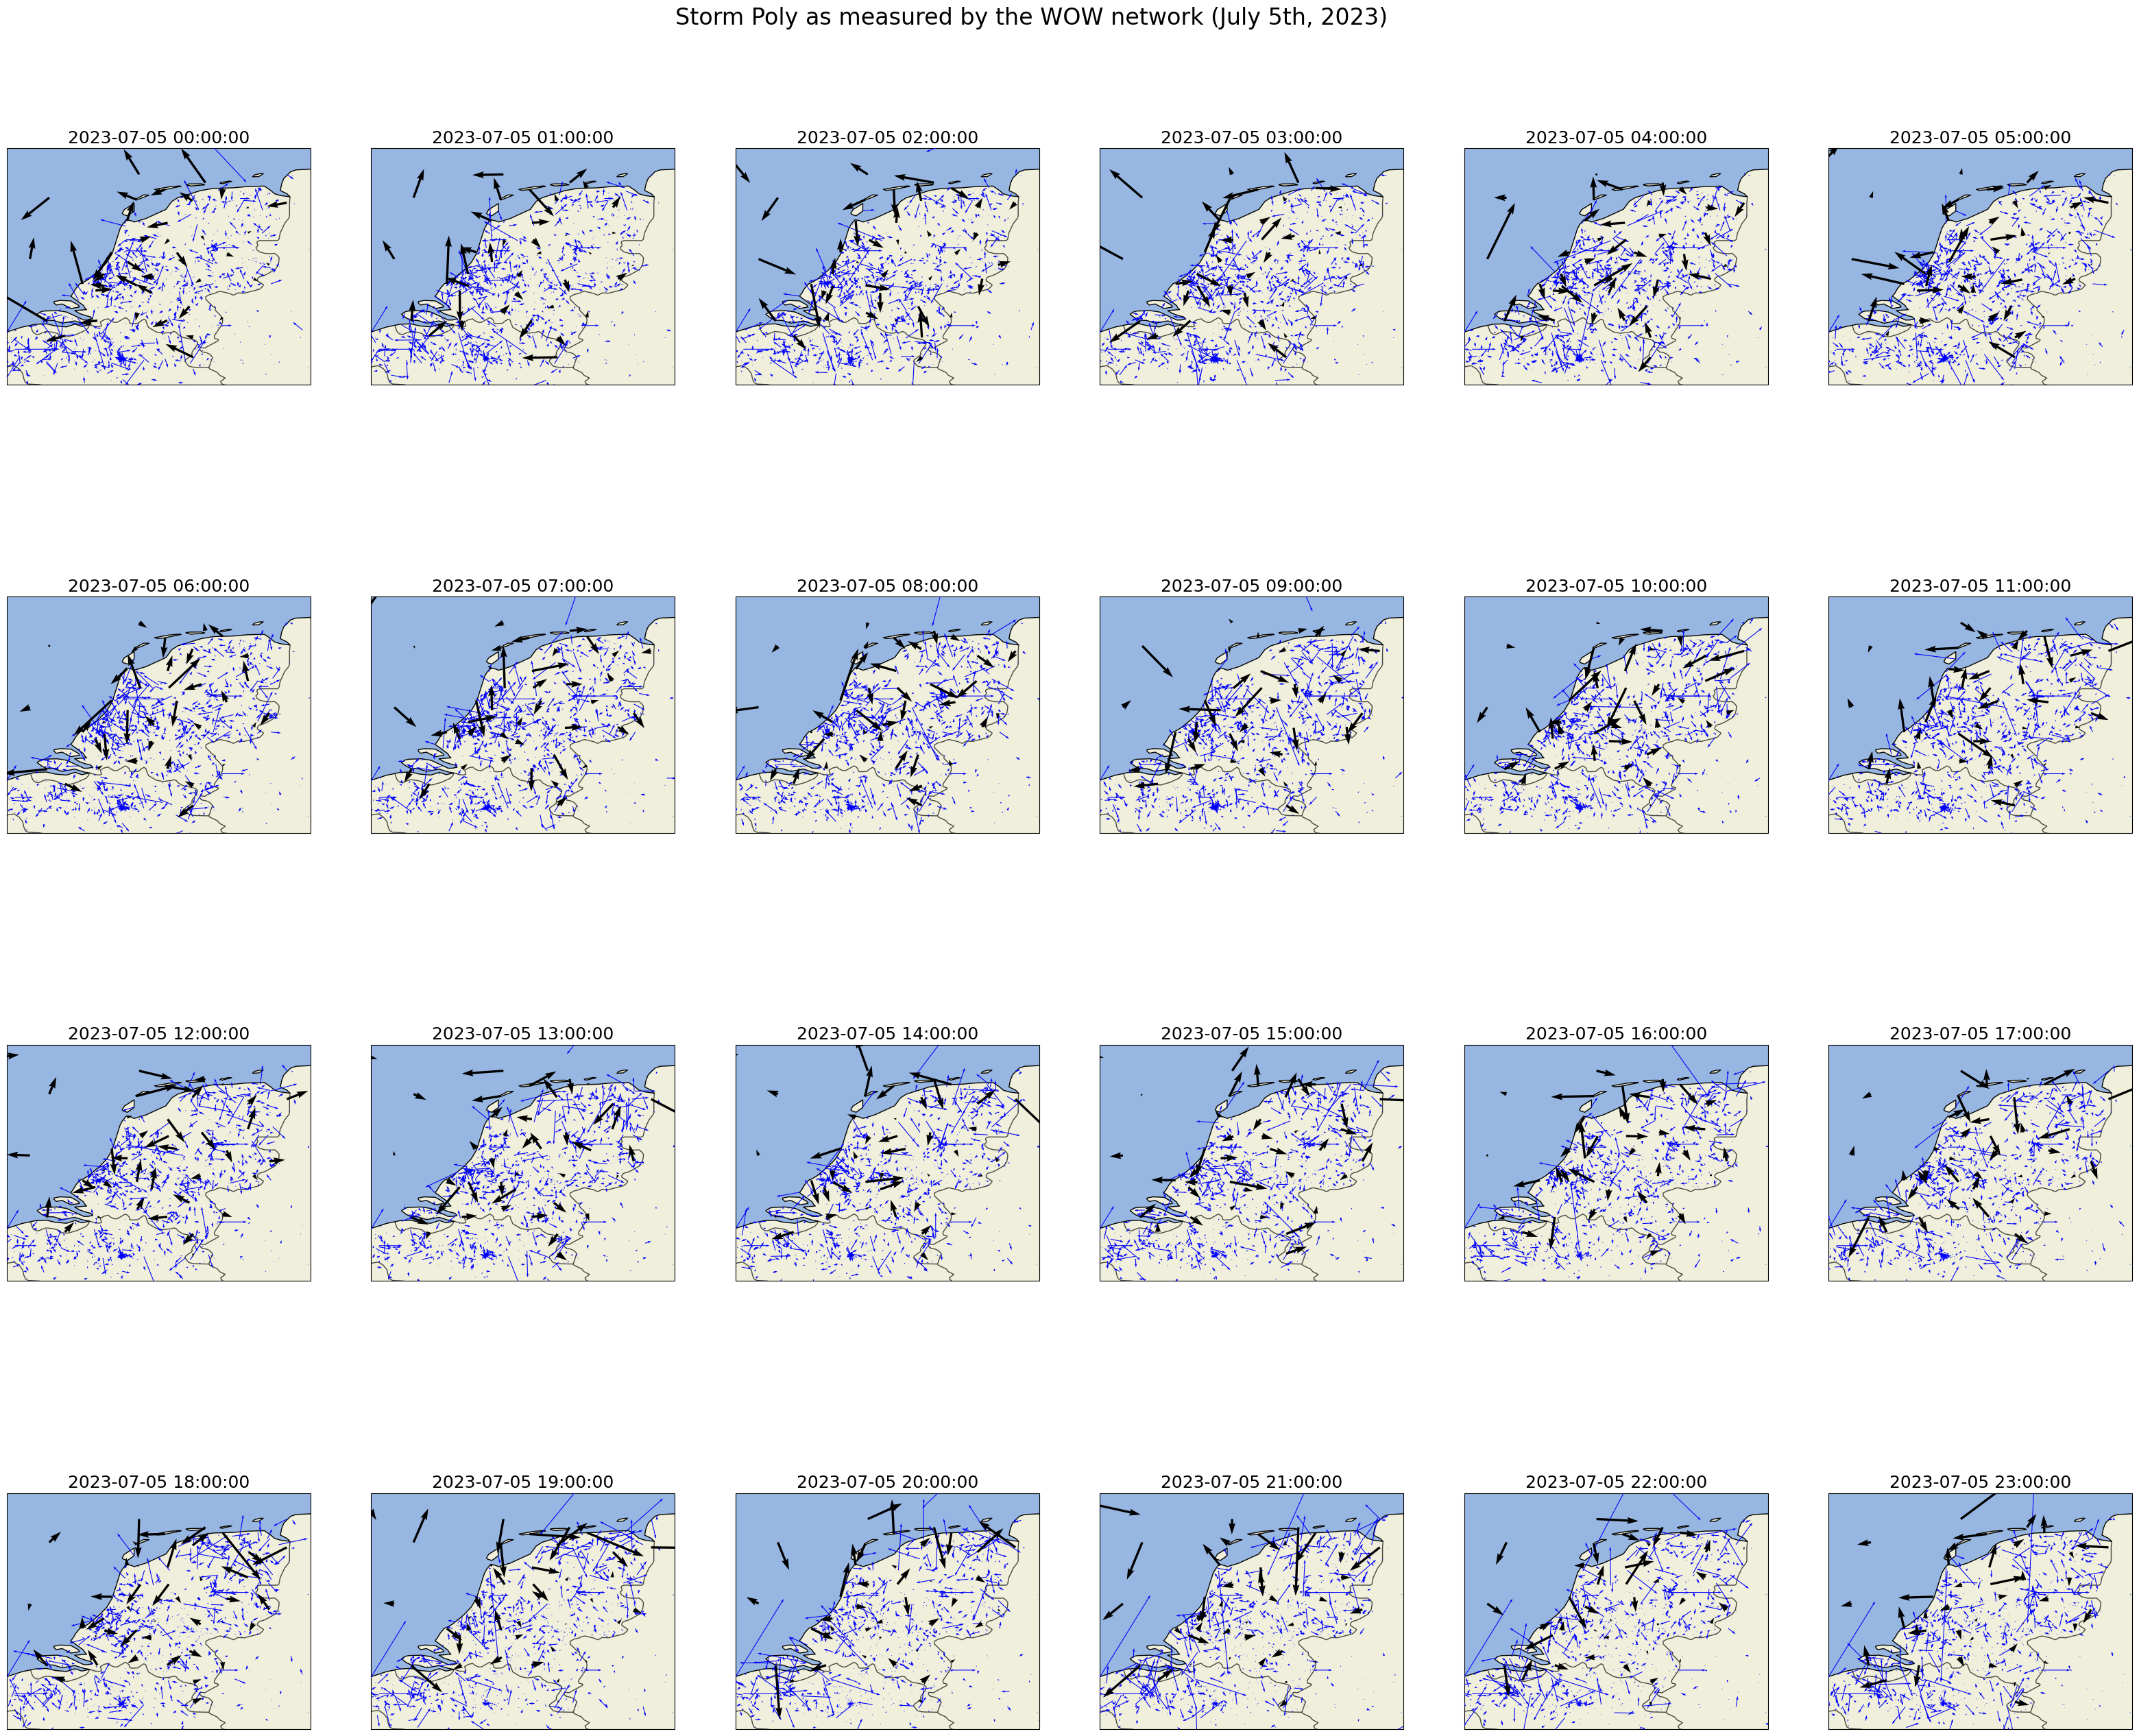

In [4]:
# Reactivate inline plotting
%matplotlib inline

i = 0
print("\nProcessing KNMI observations:")
print("-" * 30)
print()
for name_hour, group_time in groups_time_off:
    r, c = pairs[i]
    lons_off, lats_off, ucom_off, vcom_off = [[] for i in range(4)]
    groups_station_off = group_time.groupby(["SiteId"])

    for name_station, group_station in groups_station_off:
        mean_group_station = group_station[["Longitude", "Latitude", "WindSpeed_MetrePerSecond", "U", "V"]].mean()        
        lons_off.append(mean_group_station["Longitude"])
        lats_off.append(mean_group_station["Latitude"])
        ucom_off.append(mean_group_station["U"])
        vcom_off.append(mean_group_station["V"])


    print("Hour {0}, total KNMI obs: {1} \t Avg. per (SiteId, hour): {2} \t Any official value? {3}".format(name_hour, group_time.shape, len(lons_off), df_off.IsOfficial.any()))

    # Toggle these lines to have a scatter plot or quiver plots (wind direction)
    # scatter_plot_off = ax[r, c].scatter(lons_off, lats_off, c=vals_off, cmap=plt.cm.Greys, marker="s", s=24, vmin=0, vmax=32, zorder=4)    
    quiver_plot_off = ax[r, c].quiver(lons_off, lats_off, ucom_off, vcom_off, color="black", zorder=4)


    i += 1

print("\n\n")
plt.show()

Saving the figure and we are done

In [5]:
# Saving figure!
# path_ou = r"/home/jovyan/work/Pictures/extreme-events/storm-poly-jul23/WOW_Jul23_Storm_Poly_Hourly_Windspeed_quiver.png"
# plt.savefig(path_ou, bbox_inches='tight')